In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set Path

In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'CW_Dataset', 'Models', 'Code', 'Video', 'old test_functions.ipynb', 'Copy of test_functions.ipynb', 'PretrainedCNNs.ipynb']


# Load data from pkl files

The train and test datasets were saved in pkl files (in the SVM ipynb file) for faster loading

In [ ]:
import pickle

# set paths where the pkl files are located
train_data_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/train_data.pkl')
test_data_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test_data.pkl')

# load train data
with open(train_data_path, 'rb') as f:
    train_images, train_labels = pickle.load(f)

# load test data
with open(test_data_path, 'rb') as f:
    test_images, test_labels = pickle.load(f)

## Display images and labels

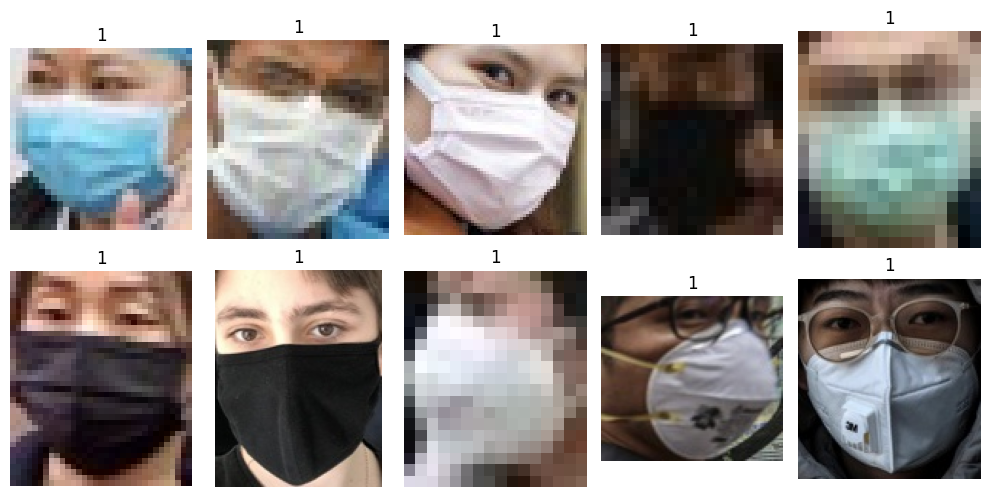

In [ ]:
import matplotlib.pyplot as plt
import random

# get 10 random images in the train images
random_indices = random.sample(range(len(train_images)), 10)

# display the 10 random images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[random_indices[i]])
    ax.set_title(train_labels[random_indices[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Get class distribution

In [ ]:
import numpy as np

# get unique labels and label counts for each label
unique_labels, label_counts = np.unique(train_labels, return_counts=True)

# zip together unique labels and label counts as tuples in a dictionary
label_counts_dict = dict(zip(unique_labels, label_counts))

# display the distribution
print("Label Counts:")
for label, count in label_counts_dict.items():
    print(f"Label {label}: {count}")

Label Counts:
Label 0: 376
Label 1: 1940
Label 2: 78


# Data preprocessing

## Data augmentation and balancing in train set

Split train data into 80% training set and 20% validation set. Resize and normalize images. Convert to tensors and dataloaders.

In [ ]:
import pickle
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import collections


#train_data_path = '/content/drive/MyDrive/Colab Notebooks/CV/train_data.pkl'
#with open(train_data_path, 'rb') as f:
#    train_images, train_labels = pickle.load(f)

# data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# normalize pixels and convert to PIL
normalized_images = [(image.astype(np.float32) / 255.0) * 255.0 for image in train_images]
train_images_pil = [Image.fromarray(image.astype(np.uint8)) for image in normalized_images]

#test_images_pil = [Image.fromarray(image) for image in test_images]

# set iamge size to resize to
image_size = (224, 224)

# define transforms: resize image, convert to tensor, and normalize pixels using mean and std from ImageNet stats
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# convert train_images and train_labels to tensors and apply transforms
train_images_tensor = torch.stack([data_transforms['train'](image) for image in train_images_pil])
train_labels_tensor = torch.tensor([int(label) for label in train_labels])

# set batch size
batch_size = 16

# split training data into 80% training and 20% validation
train_size = int(0.8 * len(train_images_tensor))  # 80% for training
val_size = len(train_images_tensor) - train_size  # remaining 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(TensorDataset(train_images_tensor, train_labels_tensor), [train_size, val_size])

# get class with most counts
label_counts = collections.Counter(train_labels_tensor.numpy())
max_samples = max(label_counts.values())

# oversampling in the training set
oversampled_images = []
oversampled_labels = []
for class_label, count in label_counts.items():
    class_indices = (train_labels_tensor == class_label).nonzero(as_tuple=True)[0]
    oversample_factor = max_samples // count
    for _ in range(oversample_factor):
        for index in class_indices:
            image = train_images_tensor[index]
            oversampled_images.append(image)
            oversampled_labels.append(class_label)

# convert oversampled images and labels to tensors
oversampled_images_tensor = torch.stack(oversampled_images)
oversampled_labels_tensor = torch.tensor(oversampled_labels)

# create dataloader for training set with oversampled data
train_loader = DataLoader(TensorDataset(oversampled_images_tensor, oversampled_labels_tensor), batch_size=batch_size, shuffle=True)

# create dataloader for validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# function to check the class distributino after oversampling
def check_class_distribution(loader):
    class_counts = collections.Counter()
    total_samples = 0

    for _, labels in loader:
        class_counts.update(labels.numpy())
        total_samples += len(labels)

    print("Class Distribution:")
    for label, count in class_counts.items():
        print(f"Class {label}: {count} samples, {count / total_samples * 100:.2f}%")

# call function for train_loader
print("Training Loader:")
check_class_distribution(train_loader)





Training Loader:
Class Distribution:
Class 1: 1940 samples, 34.08%
Class 2: 1872 samples, 32.89%
Class 0: 1880 samples, 33.03%


## Preprocessing for test set

Resize and normalize images. Convert to tensors and use dataloader.

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, TensorDataset
from torchvision import transforms
import numpy as np
from PIL import Image

# set image size to resize to
image_size = (224, 224)

# define transforms: resize image, convert to tensor, and normalize pixels using mean and std from ImageNet stats
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# conver to PIL
test_images_pil = [Image.fromarray(image) for image in test_images]

# convert test_images and test_labels to tensors and apply transforms
test_images_tensor = torch.stack([data_transforms['test'](image) for image in test_images_pil])
test_labels_tensor = torch.tensor([int(label) for label in test_labels])

# create a tensor dataset for testing
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)


# set batch size
batch_size = 16

# create dataloader for test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


## Display images

Check that they loaded correctly in the dataloaders

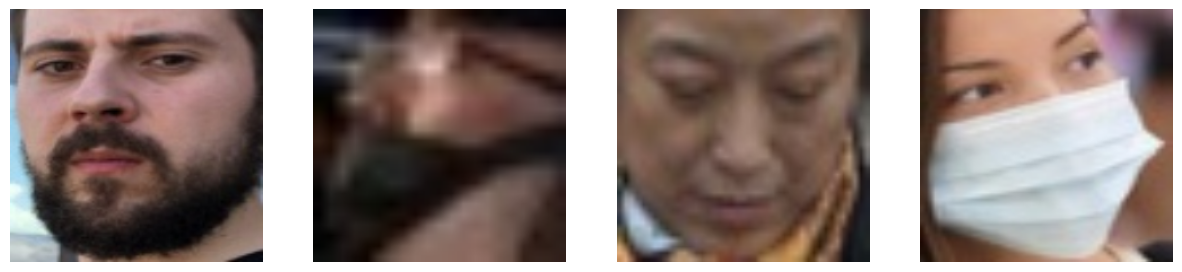

In [ ]:
# function to display images in dataloaders
def show_dataloader_images(images):

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # display 4 images
    for i in range(4):
        ax = axes[i]
        # convert tensor back to a numpy array and transpose it
        img_np = images[i].numpy().transpose((1, 2, 0))

        # denormalize the images
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

        # ensure values are in [0, 1]
        img_np = np.clip(img_np, 0, 1)

        # display image
        ax.imshow(img_np)
        ax.axis('off')

    plt.show()

# get random batch from a dataloader
images, labels = next(iter(train_loader))

# call function on images to dispaly
show_dataloader_images(images)


# Define Functions

Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

## Train function

In [ ]:
import copy
import time
import torch
import torch.nn as nn

# code reference: https://brsoff.github.io/tutorials/beginner/transfer_learning_tutorial.html

# params: model, criterion for loss function, optimizer, scheduler, train loader for train data, val loader for validation data
# number of epochs, patience for number of epochs without improvement for early stopping
def train_model(model, criterion, optimizer, scheduler, train_loader=train_loader, val_loader=val_loader, num_epochs=25, patience=10):
    since = time.time()

    # copy model to keep track of best weights
    best_model_wts = copy.deepcopy(model.state_dict())

    # create variable to keep track of best accuracy
    best_acc = 0.0

    # variable to keep track of number of epochs before early stopping
    consecutive_epochs_without_improvement = 0

    # iterate through epochs
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to train mode
                dataloader = train_loader # use train data when in train mode
            else:
                model.eval()   # set model to evaluate mode
                dataloader = val_loader # use validation data when in eval mdoe

            running_loss = 0.0 # keep track of loss
            running_corrects = 0 # keep track accuracy

            # iterate through data
            for inputs, labels in dataloader:
                # move data to gpu if available
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            # deep copy model with best accuracy on validation set
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0 # zero epoch without improvement variable
                else:
                    consecutive_epochs_without_improvement += 1 # add 1 to variable to keep track of number of epochs without improvement

        print()

        # check for early stopping
        if consecutive_epochs_without_improvement >= patience:
            print(f"No improvement for {patience} consecutive epochs. Early stopping.")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val acc: {best_acc:.4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


Train without scheduler

In [ ]:
import copy
import time
import torch
import torch.nn as nn

# code reference: https://brsoff.github.io/tutorials/beginner/transfer_learning_tutorial.html

# function same as train_model just without scheduler to update learning rate

# params: model, criterion for loss function, optimizer, train loader for train data, val loader for validation data
# number of epochs, patience for number of epochs without improvement for early stopping
def train_model_no_sch(model, criterion, optimizer, train_loader=train_loader, val_loader=val_loader, num_epochs=25, patience=10):
    since = time.time()

    # copy model to keep track of best weights
    best_model_wts = copy.deepcopy(model.state_dict())

    # create variable to keep track of best accuracy
    best_acc = 0.0

    # variable to keep track of number of epochs before early stopping
    consecutive_epochs_without_improvement = 0


    # iterate through epochs
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to train mode
                dataloader = train_loader # use train data when in train mode
            else:
                model.eval()   # set model to evaluate mode
                dataloader = val_loader # use validation data when in eval mdoe

            running_loss = 0.0 # keep track of loss
            running_corrects = 0 # keep track accuracy

            # iterate through data
            for inputs, labels in dataloader:
                # move data to gpu if available
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            # deep copy model with best accuracy on validation set
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0 # zero epoch without improvement variable
                else:
                    consecutive_epochs_without_improvement += 1 # add 1 to variable to keep track of number of epochs without improvement

        print()

        # check for early stopping
        if consecutive_epochs_without_improvement >= patience:
            print(f"No improvement for {patience} consecutive epochs. Early stopping.")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val acc: {best_acc:.4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Evaluate function

In [ ]:
from sklearn.metrics import classification_report

# create list of class labels as strings
class_names = [str(i) for i in range(3)]

# params: model to evaluate, dataloader (test_loader)
def evaluate_model(model, loader):
    model.eval() # set model to eval mode

    # create lists to keep track of true labels and predicted labels
    y_true = []
    y_pred = []

    # code reference from lab 7
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:

            # move to GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # make predictions on the images
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    if total == 0:
        return None

    accuracy = correct / total

    # get classification report and accuracy
    print("Classification Report:")
    if class_names:
        print(classification_report(y_true, y_pred, target_names=class_names))
    else:
        print(classification_report(y_true, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_true, y_pred, target_names=class_names))
    #print(f"Accuracy: {accuracy:.4f}")

    return accuracy


## Grid search with Adam function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import ParameterGrid

#grid search function that uses adam optimizer
# params: model to use, criterion for loss function, train data, validation data, param grid to iterate through, num of epochs to train for
def grid_search_adam(model, criterion, train_loader, val_loader, param_grid, num_epochs=5):
    # check of cuda is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # variables to keep track of best accuracy and best params
    best_accuracy = 0
    best_params = {}

    # perform grid search, iterate through values in param_grid
    for params in ParameterGrid(param_grid):
        print("Training with params:", params)

        # move model to the right device
        model.to(device)

        # create adam optimizer with learning rate for current iteration
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        # move optimizer to right device
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
        # create scheduler with step size and gamma values for current iteration
        scheduler = StepLR(optimizer, step_size=params['step_size'], gamma=params['gamma'])

        # train model
        model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)
        # get accuracy from evaluate_model and validation set
        accuracy = evaluate_model(model, val_loader)

        print("Validation accuracy:", accuracy)

        # update best accuracy and best params
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params

    print("Best parameters:", best_params)
    print("Best validation accuracy:", best_accuracy)

## Grid search with SGD function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import ParameterGrid

#grid search function that uses SGD optimizer
# params: model to use, criterion for loss function, train data, validation data, param grid to iterate through, num of epochs to train for
def grid_search_sgd(model, criterion, train_loader, val_loader, param_grid, num_epochs=5):
    # check of cuda is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # variables to keep track of best accuracy and best params
    best_accuracy = 0
    best_params = {}

    # perform grid search, iterate through values in param_grid
    for params in ParameterGrid(param_grid):
        print("Training with params:", params)

        # move model to the right device
        model.to(device)

        # create SGD optimizer with learning rate and momentum for current iteration
        optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])
        # move optimizer to right device
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)

        # create scheduler with step size and gamma values for current iteration
        scheduler = StepLR(optimizer, step_size=params['step_size'], gamma=params['gamma'])

        # train model
        model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)
        # get accuracy from evaluate_model and validation set
        accuracy = evaluate_model(model, val_loader)

        print("Validation accuracy:", accuracy)

        # update best accuracy and best params
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params

    print("Best parameters:", best_params)
    print("Best validation accuracy:", best_accuracy)

# Models

## Model 1 (Resnet-50)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# references: https://www.wolframcloud.com/objects/notebookarchive/submissions/2020-12-6z8vw5z/2020-12-6z8vw5z.nb
# https://www.mdpi.com/2073-431X/13/1/7

# load pretrained resnet-50 model
model_resnet50_4 = models.resnet50(weights='IMAGENET1K_V1')

# remove last 2 layers
backbone = nn.Sequential(*list(model_resnet50_4.children())[:-2])

# freeze the weights of the backbone layers
for param in backbone.parameters():
    param.requires_grad = False

# set number of output features from the backbone
num_ftrs = 2048

# define the classifier
classifier = nn.Sequential(
    nn.Dropout(0.2), # dropout layer with dropout rate 0.2
    nn.Linear(num_ftrs, 300), # linear layer with 300 output features
    nn.ReLU(), # relu activation function
    nn.Dropout(0.2), # dropout layer with dropout rate 0.2
    nn.Linear(300, 3), # linear layer with 3 output features
    nn.Softmax(dim=1) # softmax activation function for multiclass classification
)

# add classifer to backbone
model_resnet50_4 = nn.Sequential(
    backbone,
    nn.AdaptiveAvgPool2d((1, 1)), # adaptive avg pooling to convert features to 1x1
    nn.Flatten(), # flatten the features
    classifier
)

# create cross entropy loss function
criterion = nn.CrossEntropyLoss()




### Grid search

In [ ]:
# define the hyperparameters grid
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    #'momentum': [0.9, 0.95],
    'step_size': [5, 10, 15],
    'gamma': [0.1, 0.2, 0.3]
}

In [ ]:
grid_search_adam(model_resnet50_4, criterion, train_loader, val_loader,param_grid)

Using device: cuda
Training with params: {'gamma': 0.1, 'lr': 0.001, 'step_size': 5}
Epoch 0/4
----------------
train loss: 1.0036 acc: 0.5107
val loss: 0.8688 acc: 0.6743

Epoch 1/4
----------------
train loss: 0.8993 acc: 0.6307
val loss: 0.8969 acc: 0.6284

Epoch 2/4
----------------
train loss: 0.8657 acc: 0.6711
val loss: 0.7262 acc: 0.8246

Epoch 3/4
----------------
train loss: 0.8522 acc: 0.6866
val loss: 0.9029 acc: 0.6221

Epoch 4/4
----------------
train loss: 0.8456 acc: 0.6934
val loss: 0.8049 acc: 0.7474

Training complete in 1m 39s
Best val acc: 0.8246
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.95      0.64        61
           1       0.98      0.83      0.90       398
           2       0.30      0.35      0.33        20

    accuracy                           0.82       479
   macro avg       0.59      0.71      0.62       479
weighted avg       0.89      0.82      0.84       479

Accuracy: 0.8246
Valid

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2189 acc: 0.3319
val loss: 1.4241 acc: 0.1273

Epoch 1/4
----------------
train loss: 1.2236 acc: 0.3270
val loss: 1.4241 acc: 0.1273

Epoch 2/4
----------------
train loss: 1.2179 acc: 0.3331
val loss: 1.4241 acc: 0.1273

Epoch 3/4
----------------
train loss: 1.2123 acc: 0.3389
val loss: 1.4241 acc: 0.1273

Epoch 4/4
----------------
train loss: 1.2214 acc: 0.3298
val loss: 1.4241 acc: 0.1273

Training complete in 1m 48s
Best val acc: 0.1273
Classification Report:
              precision    recall  f1-score   support

           0       0.13      1.00      0.23        61
           1       0.00      0.00      0.00       398
           2       0.00      0.00      0.00        20

    accuracy                           0.13       479
   macro avg       0.04      0.33      0.08       479
weighted avg       0.02      0.13      0.03       479

Accuracy: 0.1273
Validation accuracy: 0.12734864300626306
Training with params: {'gamma': 0.1, 'lr': 0.01, 'step_size': 15}
Epoch 0/4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2281 acc: 0.3233
val loss: 1.4241 acc: 0.1273

Epoch 1/4
----------------
train loss: 1.2267 acc: 0.3247
val loss: 1.4241 acc: 0.1273

Epoch 2/4
----------------
train loss: 1.2143 acc: 0.3368
val loss: 1.4241 acc: 0.1273

Epoch 3/4
----------------
train loss: 1.2145 acc: 0.3370
val loss: 1.4241 acc: 0.1273

Epoch 4/4
----------------
train loss: 1.2208 acc: 0.3308
val loss: 1.4241 acc: 0.1273

Training complete in 1m 41s
Best val acc: 0.1273
Classification Report:
              precision    recall  f1-score   support

           0       0.13      1.00      0.23        61
           1       0.00      0.00      0.00       398
           2       0.00      0.00      0.00        20

    accuracy                           0.13       479
   macro avg       0.04      0.33      0.08       479
weighted avg       0.02      0.13      0.03       479

Accuracy: 0.1273
Validation accuracy: 0.12734864300626306
Training with params: {'gamma': 0.1, 'lr': 0.1, 'step_size': 5}
Epoch 0/4
--

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2251 acc: 0.3262
val loss: 1.4241 acc: 0.1273

Epoch 1/4
----------------
train loss: 1.2139 acc: 0.3375
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2113 acc: 0.3401
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2129 acc: 0.3385
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2104 acc: 0.3410
val loss: 0.7205 acc: 0.8309

Training complete in 1m 38s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.1, 'lr': 0.1, 'step_size': 10}
Epoch 0/4
--

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2124 acc: 0.3391
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2034 acc: 0.3480
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2145 acc: 0.3370
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2080 acc: 0.3435
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2152 acc: 0.3361
val loss: 0.7205 acc: 0.8309

Training complete in 1m 38s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.1, 'lr': 0.1, 'step_size': 15}
Epoch 0/4
--

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2137 acc: 0.3377
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2170 acc: 0.3345
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2111 acc: 0.3403
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2080 acc: 0.3435
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2052 acc: 0.3463
val loss: 0.7205 acc: 0.8309

Training complete in 1m 37s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.2, 'lr': 0.001, 'step_size': 5}
Epoch 0/4
-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2164 acc: 0.3350
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2120 acc: 0.3394
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2111 acc: 0.3403
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2175 acc: 0.3340
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2069 acc: 0.3445
val loss: 0.7205 acc: 0.8309

Training complete in 1m 37s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.2, 'lr': 0.001, 'step_size': 10}
Epoch 0/4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2173 acc: 0.3342
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2132 acc: 0.3382
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2155 acc: 0.3359
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2120 acc: 0.3394
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2117 acc: 0.3398
val loss: 0.7205 acc: 0.8309

Training complete in 1m 37s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.2, 'lr': 0.001, 'step_size': 15}
Epoch 0/4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2080 acc: 0.3435
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2106 acc: 0.3408
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2097 acc: 0.3417
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2110 acc: 0.3405
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2155 acc: 0.3359
val loss: 0.7205 acc: 0.8309

Training complete in 1m 37s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.2, 'lr': 0.01, 'step_size': 5}
Epoch 0/4
--

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2088 acc: 0.3426
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2148 acc: 0.3366
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2088 acc: 0.3426
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2066 acc: 0.3447
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2163 acc: 0.3352
val loss: 0.7205 acc: 0.8309

Training complete in 1m 36s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.2, 'lr': 0.01, 'step_size': 10}
Epoch 0/4
-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2148 acc: 0.3366
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2155 acc: 0.3359
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2116 acc: 0.3394
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2112 acc: 0.3398
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2119 acc: 0.3394
val loss: 0.7205 acc: 0.8309

Training complete in 1m 38s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.2, 'lr': 0.01, 'step_size': 15}
Epoch 0/4
-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2121 acc: 0.3392
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2129 acc: 0.3384
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2134 acc: 0.3380
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2182 acc: 0.3333
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2159 acc: 0.3356
val loss: 0.7205 acc: 0.8309

Training complete in 1m 41s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.2, 'lr': 0.1, 'step_size': 5}
Epoch 0/4
---

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2138 acc: 0.3375
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2130 acc: 0.3384
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2121 acc: 0.3392
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2117 acc: 0.3398
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2106 acc: 0.3408
val loss: 0.7205 acc: 0.8309

Training complete in 1m 38s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.2, 'lr': 0.1, 'step_size': 10}
Epoch 0/4
--

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2031 acc: 0.3484
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2187 acc: 0.3327
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2103 acc: 0.3412
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2139 acc: 0.3375
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2190 acc: 0.3324
val loss: 0.7205 acc: 0.8309

Training complete in 1m 38s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.2, 'lr': 0.1, 'step_size': 15}
Epoch 0/4
--

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2096 acc: 0.3419
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2082 acc: 0.3433
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2175 acc: 0.3340
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2060 acc: 0.3454
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2098 acc: 0.3417
val loss: 0.7205 acc: 0.8309

Training complete in 1m 40s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.3, 'lr': 0.001, 'step_size': 5}
Epoch 0/4
-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2201 acc: 0.3313
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2103 acc: 0.3412
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2055 acc: 0.3459
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2089 acc: 0.3426
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2076 acc: 0.3438
val loss: 0.7205 acc: 0.8309

Training complete in 1m 39s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.3, 'lr': 0.001, 'step_size': 10}
Epoch 0/4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2162 acc: 0.3352
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2106 acc: 0.3408
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2145 acc: 0.3370
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2213 acc: 0.3301
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2190 acc: 0.3324
val loss: 0.7205 acc: 0.8309

Training complete in 1m 38s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.3, 'lr': 0.001, 'step_size': 15}
Epoch 0/4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2133 acc: 0.3382
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2201 acc: 0.3313
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2180 acc: 0.3335
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2140 acc: 0.3375
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2115 acc: 0.3400
val loss: 0.7205 acc: 0.8309

Training complete in 1m 38s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.3, 'lr': 0.01, 'step_size': 5}
Epoch 0/4
--

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2192 acc: 0.3322
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2108 acc: 0.3407
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2199 acc: 0.3315
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2141 acc: 0.3373
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2161 acc: 0.3354
val loss: 0.7205 acc: 0.8309

Training complete in 1m 39s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.3, 'lr': 0.01, 'step_size': 10}
Epoch 0/4
-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2129 acc: 0.3385
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2148 acc: 0.3366
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2161 acc: 0.3354
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2060 acc: 0.3454
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2133 acc: 0.3382
val loss: 0.7205 acc: 0.8309

Training complete in 1m 39s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.3, 'lr': 0.01, 'step_size': 15}
Epoch 0/4
-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2215 acc: 0.3299
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2110 acc: 0.3405
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2071 acc: 0.3443
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2145 acc: 0.3370
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2125 acc: 0.3389
val loss: 0.7205 acc: 0.8309

Training complete in 1m 38s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.3, 'lr': 0.1, 'step_size': 5}
Epoch 0/4
---

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2135 acc: 0.3378
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2115 acc: 0.3400
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2243 acc: 0.3271
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2110 acc: 0.3405
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2059 acc: 0.3456
val loss: 0.7205 acc: 0.8309

Training complete in 1m 39s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.3, 'lr': 0.1, 'step_size': 10}
Epoch 0/4
--

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2107 acc: 0.3405
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2117 acc: 0.3398
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2169 acc: 0.3345
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2162 acc: 0.3352
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2206 acc: 0.3308
val loss: 0.7205 acc: 0.8309

Training complete in 1m 41s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Training with params: {'gamma': 0.3, 'lr': 0.1, 'step_size': 15}
Epoch 0/4
--

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2165 acc: 0.3347
val loss: 0.7205 acc: 0.8309

Epoch 1/4
----------------
train loss: 1.2224 acc: 0.3291
val loss: 0.7205 acc: 0.8309

Epoch 2/4
----------------
train loss: 1.2146 acc: 0.3368
val loss: 0.7205 acc: 0.8309

Epoch 3/4
----------------
train loss: 1.2125 acc: 0.3389
val loss: 0.7205 acc: 0.8309

Epoch 4/4
----------------
train loss: 1.2089 acc: 0.3426
val loss: 0.7205 acc: 0.8309

Training complete in 1m 38s
Best val acc: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.83      1.00      0.91       398
           2       0.00      0.00      0.00        20

    accuracy                           0.83       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.69      0.83      0.75       479

Accuracy: 0.8309
Validation accuracy: 0.8308977035490606
Best parameters: {'gamma': 0.1, 'lr': 0.001, 'step_size': 10}
Best validation

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Train model

In [ ]:
# set values in the optimizer and scheduler found through grid search
criterion = nn.CrossEntropyLoss()

optimizer_adam = optim.Adam(model_resnet50_4.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer_adam, step_size=15, gamma=0.1)

In [ ]:
model_resnet50_4 = train_model(model_resnet50_4, criterion, optimizer_adam, scheduler, train_loader, val_loader,
                       num_epochs=100)

Epoch 0/99
----------------
train loss: 1.2139 acc: 0.3375
val loss: 1.2364 acc: 0.3150

Epoch 1/99
----------------
train loss: 1.2139 acc: 0.3375
val loss: 1.2364 acc: 0.3150

Epoch 2/99
----------------
train loss: 1.2142 acc: 0.3373
val loss: 1.2364 acc: 0.3150

Epoch 3/99
----------------
train loss: 1.2143 acc: 0.3371
val loss: 1.2364 acc: 0.3150

Epoch 4/99
----------------
train loss: 1.2126 acc: 0.3387
val loss: 1.2364 acc: 0.3150

Epoch 5/99
----------------
train loss: 1.2140 acc: 0.3375
val loss: 1.2364 acc: 0.3150

Epoch 6/99
----------------
train loss: 1.2134 acc: 0.3381
val loss: 1.2364 acc: 0.3150

Epoch 7/99
----------------
train loss: 1.2145 acc: 0.3369
val loss: 1.2364 acc: 0.3150

Epoch 8/99
----------------
train loss: 1.2144 acc: 0.3371
val loss: 1.2364 acc: 0.3150

Epoch 9/99
----------------
train loss: 1.2138 acc: 0.3375
val loss: 1.2364 acc: 0.3150

Epoch 10/99
----------------
train loss: 1.2119 acc: 0.3396
val loss: 1.2364 acc: 0.3150

No improvement for 1

### Test model

In [ ]:
evaluate_model(model_resnet50_4, test_loader)

Classification Report:
              precision    recall  f1-score   support

           0       0.11      1.00      0.20        51
           1       0.00      0.00      0.00       388
           2       0.00      0.00      0.00        19

    accuracy                           0.11       458
   macro avg       0.04      0.33      0.07       458
weighted avg       0.01      0.11      0.02       458

Accuracy: 0.1114


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.11135371179039301

## Model 2 (Resnet-50)

Testing without adding layers

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# load pretrained resnet-50 model
model_resnet50_5 = models.resnet50(weights='IMAGENET1K_V1')

# remove last 2 layers
backbone = nn.Sequential(*list(model_resnet50_5.children())[:-2])

# freeze the weights of the backbone layers
for param in backbone.parameters():
    param.requires_grad = False

# set number of output features from the backbone
num_ftrs = 2048

# Define the criterion for calculating the loss
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Grid search

In [ ]:
# define the hyperparameters grid
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    #'momentum': [0.9, 0.95],
    'step_size': [5, 10, 15],
    'gamma': [0.1, 0.2, 0.3]
}

In [ ]:
grid_search_adam(model_resnet50_5, criterion, train_loader, val_loader,param_grid)

Using device: cuda
Training with params: {'gamma': 0.1, 'lr': 0.001, 'step_size': 5}
Epoch 0/4
----------------
train loss: 0.6844 acc: 0.7092
val loss: 0.5789 acc: 0.7641

Epoch 1/4
----------------
train loss: 0.6668 acc: 0.7296
val loss: 0.3444 acc: 0.8601

Epoch 2/4
----------------
train loss: 0.6386 acc: 0.7405
val loss: 0.2827 acc: 0.8998

Epoch 3/4
----------------
train loss: 0.5976 acc: 0.7558
val loss: 0.3165 acc: 0.8727

Epoch 4/4
----------------
train loss: 0.5963 acc: 0.7605
val loss: 0.4564 acc: 0.8205

Training complete in 1m 36s
Best val acc: 0.8998
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        61
           1       0.98      0.90      0.94       398
           2       0.37      0.75      0.49        20

    accuracy                           0.90       479
   macro avg       0.71      0.86      0.76       479
weighted avg       0.93      0.90      0.91       479

Accuracy: 0.8998
Valid

### Train model

In [ ]:
# set values in the optimizer and scheduler found through grid search

criterion = nn.CrossEntropyLoss()

optimizer_adam = optim.Adam(model_resnet50_5.parameters(), lr=0.01)

scheduler = lr_scheduler.StepLR(optimizer_adam, step_size=5, gamma=0.2)

In [ ]:
model_resnet50_5 = train_model(model_resnet50_5, criterion, optimizer_adam, scheduler, train_loader, val_loader,
                       num_epochs=100)

Epoch 0/99
----------------
train loss: 8.2965 acc: 0.8661
val loss: 3.6240 acc: 0.9395

Epoch 1/99
----------------
train loss: 7.9480 acc: 0.8668
val loss: 4.8638 acc: 0.9248

Epoch 2/99
----------------
train loss: 7.3639 acc: 0.8753
val loss: 4.3360 acc: 0.9311

Epoch 3/99
----------------
train loss: 6.7841 acc: 0.8765
val loss: 4.1787 acc: 0.9332

Epoch 4/99
----------------
train loss: 6.8161 acc: 0.8790
val loss: 3.9626 acc: 0.9228

Epoch 5/99
----------------
train loss: 5.5816 acc: 0.8884
val loss: 4.0952 acc: 0.9186

Epoch 6/99
----------------
train loss: 5.7625 acc: 0.8860
val loss: 6.1414 acc: 0.8914

Epoch 7/99
----------------
train loss: 5.8014 acc: 0.8798
val loss: 3.3152 acc: 0.9269

Epoch 8/99
----------------
train loss: 5.9508 acc: 0.8791
val loss: 4.4295 acc: 0.9228

Epoch 9/99
----------------
train loss: 5.1977 acc: 0.8913
val loss: 2.5556 acc: 0.9457

Epoch 10/99
----------------
train loss: 5.3412 acc: 0.8967
val loss: 4.7859 acc: 0.9040

Epoch 11/99
--------

### Test model

In [ ]:
evaluate_model(model_resnet50_5, test_loader)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        51
           1       0.97      0.94      0.95       388
           2       0.56      0.53      0.54        19

    accuracy                           0.92       458
   macro avg       0.75      0.79      0.76       458
weighted avg       0.92      0.92      0.92       458

Accuracy: 0.9170


0.9170305676855895

## Model 3 (Resnet-50)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# references: https://www.wolframcloud.com/objects/notebookarchive/submissions/2020-12-6z8vw5z/2020-12-6z8vw5z.nb
# https://www.mdpi.com/2073-431X/13/1/7

# load pretrained resnet-50 model
model_resnet50_7 = models.resnet50(weights='IMAGENET1K_V1')

# remove last 2 layers
backbone = nn.Sequential(*list(model_resnet50_7.children())[:-2])

# freeze the weights of the backbone layers
for param in backbone.parameters():
    param.requires_grad = False

# set number of output features from the backbone
num_ftrs = 2048

# Define the classifier
classifier = nn.Sequential(
    nn.Flatten(), # flatten features
    nn.Linear(num_ftrs, 512), # linear layer with 512 output features
    nn.ReLU(), # relu activation function
    nn.Dropout(0.2), # dropout layer with dropout rate 0.5
    nn.Linear(512, 3), # linear layer with 3 output features
    nn.Softmax(dim=1) # softmax activation function for multiclass classification
)

# add classifer to backbone
model_resnet50_7 = nn.Sequential(
    backbone,
    nn.AdaptiveAvgPool2d((1, 1)), # adaptive avg pooling to convert features to 1x1
    classifier
)

# create cross entropy loss function
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train model

In [ ]:
criterion = nn.CrossEntropyLoss()

# set learning rate value in the optimizer
optimizer_adam = optim.Adam(model_resnet50_7.parameters(), lr=0.0001)

In [ ]:
# move model to right device
model_resnet50_7.to(device)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [ ]:
model_resnet50_7 = train_model_no_sch(model_resnet50_7, criterion, optimizer_adam, train_loader, val_loader,
                       num_epochs=250, patience=25)

Epoch 0/249
----------------
train loss: 1.0976 acc: 0.3554
val loss: 1.0835 acc: 0.5511

Epoch 1/249
----------------
train loss: 1.0976 acc: 0.3602
val loss: 1.0840 acc: 0.5428

Epoch 2/249
----------------
train loss: 1.0981 acc: 0.3563
val loss: 1.0843 acc: 0.5261

Epoch 3/249
----------------
train loss: 1.0981 acc: 0.3507
val loss: 1.0842 acc: 0.5324

Epoch 4/249
----------------
train loss: 1.0975 acc: 0.3610
val loss: 1.0835 acc: 0.5428

Epoch 5/249
----------------
train loss: 1.0973 acc: 0.3573
val loss: 1.0843 acc: 0.5449

Epoch 6/249
----------------
train loss: 1.0976 acc: 0.3524
val loss: 1.0836 acc: 0.5637

Epoch 7/249
----------------
train loss: 1.0977 acc: 0.3508
val loss: 1.0841 acc: 0.5303

Epoch 8/249
----------------
train loss: 1.0981 acc: 0.3445
val loss: 1.0832 acc: 0.5658

Epoch 9/249
----------------
train loss: 1.0977 acc: 0.3558
val loss: 1.0831 acc: 0.5637

Epoch 10/249
----------------
train loss: 1.0974 acc: 0.3624
val loss: 1.0843 acc: 0.5449

Epoch 11/

### Test model

In [ ]:
evaluate_model(model_resnet50_7, test_loader)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.88      0.76      0.81       388
           2       0.06      0.42      0.11        19

    accuracy                           0.66       458
   macro avg       0.31      0.39      0.31       458
weighted avg       0.75      0.66      0.69       458

Accuracy: 0.6594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6593886462882096

## Model 4 (Resnet-50) - Best Resnet-50, used in report and test_functions

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# references: https://www.wolframcloud.com/objects/notebookarchive/submissions/2020-12-6z8vw5z/2020-12-6z8vw5z.nb
# https://www.mdpi.com/2073-431X/13/1/7

# load pretrained resnet-50 model
model_resnet50_9 = models.resnet50(weights='IMAGENET1K_V1')

# remove last 2 layers
backbone = nn.Sequential(*list(model_resnet50_9.children())[:-2])

# freeze the weights of the backbone layers
for param in backbone.parameters():
    param.requires_grad = False

# set number of output features from the backbone
num_ftrs = 2048

# define the classifier
classifier = nn.Sequential(
    nn.Dropout(0.2), # dropout layer with dropout rate 0.2
    nn.Linear(num_ftrs, 300), # linear layer with 300 output features
    nn.ReLU(), # relu activation function
    nn.Dropout(0.2), # dropout layer with dropout rate 0.2
    nn.Linear(300, 3), # linear layer with 3 output features
    nn.Softmax(dim=1) # softmax activation function for multiclass classification
)

# add classifer to backbone
model_resnet50_9 = nn.Sequential(
    backbone,
    nn.AdaptiveAvgPool2d((1, 1)), # ddaptive average pooling to convert features to 1x1
    nn.Flatten(), flatten features
    classifier
)

# create cross entropy loss function
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 38.5MB/s]


### Train model

In [ ]:
criterion = nn.CrossEntropyLoss()

# set learning rate value in the optimizer
optimizer_adam = optim.Adam(model_resnet50_9.parameters(), lr=0.0001)

In [ ]:
# move model to right device
model_resnet50_9.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [ ]:
model_resnet50_9 = train_model_no_sch(model_resnet50_9, criterion, optimizer_adam, train_loader, val_loader,
                       num_epochs=250, patience=25)

Epoch 0/249
----------------
train loss: 0.9468 acc: 0.6383
val loss: 0.7528 acc: 0.8810

Epoch 1/249
----------------
train loss: 0.8107 acc: 0.7776
val loss: 0.7644 acc: 0.8100

Epoch 2/249
----------------
train loss: 0.7814 acc: 0.7927
val loss: 0.6971 acc: 0.8768

Epoch 3/249
----------------
train loss: 0.7530 acc: 0.8166
val loss: 0.6926 acc: 0.8768

Epoch 4/249
----------------
train loss: 0.7440 acc: 0.8212
val loss: 0.6944 acc: 0.8727

Epoch 5/249
----------------
train loss: 0.7348 acc: 0.8285
val loss: 0.6855 acc: 0.8685

Epoch 6/249
----------------
train loss: 0.7292 acc: 0.8298
val loss: 0.7790 acc: 0.7641

Epoch 7/249
----------------
train loss: 0.7181 acc: 0.8456
val loss: 0.7239 acc: 0.8309

Epoch 8/249
----------------
train loss: 0.7114 acc: 0.8484
val loss: 0.6303 acc: 0.9290

Epoch 9/249
----------------
train loss: 0.7091 acc: 0.8491
val loss: 0.6924 acc: 0.8664

Epoch 10/249
----------------
train loss: 0.7050 acc: 0.8514
val loss: 0.7491 acc: 0.7933

Epoch 11/

### Test model

In [ ]:
evaluate_model(model_resnet50_9, test_loader)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        51
           1       0.96      0.97      0.96       388
           2       0.67      0.42      0.52        19

    accuracy                           0.93       458
   macro avg       0.82      0.75      0.77       458
weighted avg       0.93      0.93      0.93       458

Accuracy: 0.9345


0.9344978165938864

In [ ]:
# save model
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models/resnet50_9.pth')
torch.save(model_resnet50_9.state_dict(), PATH)

## Model 5 (Mobilenet)

In [ ]:
# load pretrained mobilenet V2 model
mobilenet2 = models.mobilenet_v2(weights="IMAGENET1K_V1")

# freeze weights of the backbone layers
for param in mobilenet2.parameters():
    param.requires_grad = False

num_features = mobilenet2.classifier[-1].in_features
mobilenet2.classifier = nn.Sequential(
    nn.Dropout(0.2),  # dropout layer with 0.2 dropout rate
    nn.Linear(num_features, 3),  # linear layer
    nn.Softmax(dim=1)   # softmax activation function for multiclass classification
)

# create cross entropy loss function
criterion = nn.CrossEntropyLoss()

# create adam optimizer
optimizer_adam = torch.optim.Adam(mobilenet2.parameters(), lr=0.0001)

In [ ]:
# move model to right device
mobilenet2.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### Train model

In [ ]:
mobilenet2 = train_model_no_sch(mobilenet2, criterion, optimizer_adam, train_loader, val_loader,
                       num_epochs=250, patience=25)

Epoch 0/249
----------------
train loss: 1.0323 acc: 0.5546
val loss: 0.9113 acc: 0.8163

Epoch 1/249
----------------
train loss: 0.9321 acc: 0.7064
val loss: 0.8412 acc: 0.8601

Epoch 2/249
----------------
train loss: 0.8836 acc: 0.7526
val loss: 0.7948 acc: 0.8706

Epoch 3/249
----------------
train loss: 0.8539 acc: 0.7711
val loss: 0.7866 acc: 0.8747

Epoch 4/249
----------------
train loss: 0.8315 acc: 0.7839
val loss: 0.7760 acc: 0.8434

Epoch 5/249
----------------
train loss: 0.8149 acc: 0.7957
val loss: 0.7458 acc: 0.8747

Epoch 6/249
----------------
train loss: 0.8052 acc: 0.8039
val loss: 0.7396 acc: 0.8685

Epoch 7/249
----------------
train loss: 0.7932 acc: 0.8148
val loss: 0.7184 acc: 0.8914

Epoch 8/249
----------------
train loss: 0.7849 acc: 0.8148
val loss: 0.7048 acc: 0.8977

Epoch 9/249
----------------
train loss: 0.7844 acc: 0.8078
val loss: 0.7240 acc: 0.8789

Epoch 10/249
----------------
train loss: 0.7745 acc: 0.8199
val loss: 0.7134 acc: 0.8768

Epoch 11/

### Test model

In [ ]:
evaluate_model(mobilenet2, test_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        51
           1       0.97      0.96      0.97       388
           2       0.38      0.42      0.40        19

    accuracy                           0.93       458
   macro avg       0.74      0.75      0.75       458
weighted avg       0.93      0.93      0.93       458

Accuracy: 0.9301


0.9301310043668122

## Model 6 (Mobilenet) - Best Mobilenet, used in report and test_functions

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# references: https://www.wolframcloud.com/objects/notebookarchive/submissions/2020-12-6z8vw5z/2020-12-6z8vw5z.nb
# https://www.mdpi.com/2073-431X/13/1/7

# load pretrained mobilenet V2 model
mobilenet3 = models.mobilenet_v2(weights='IMAGENET1K_V1')

# freeze weights of the backbone layers
for param in mobilenet3.parameters():
    param.requires_grad = False

# number of output features from the backbone
num_ftrs = mobilenet3.classifier[-1].in_features

# define new classifier
# same architecture as best resnet-50 model
classifier = nn.Sequential(
    nn.Dropout(0.2), # dropout layer with dropout rate 0.2
    nn.Linear(num_ftrs, 300), # linear layer with 300 output features
    nn.ReLU(), # relu activation function
    nn.Dropout(0.2), # dropout layer with dropout rate 0.2
    nn.Linear(300, 3), # linear layer with 3 output features
    nn.Softmax(dim=1) # softmax activation function for multiclass classification
)

# replace the classifier in MobileNetV2
mobilenet3.classifier = classifier

# create cross entropy loss function
criterion = nn.CrossEntropyLoss()


### Train model

In [ ]:
mobilenet3 = train_model_no_sch(mobilenet3, criterion, optimizer_adam, train_loader, val_loader,
                       num_epochs=250, patience=25)

Epoch 0/249
----------------
train loss: 0.9348 acc: 0.6687
val loss: 0.7824 acc: 0.8225

Epoch 1/249
----------------
train loss: 0.8006 acc: 0.7862
val loss: 0.7237 acc: 0.8580

Epoch 2/249
----------------
train loss: 0.7624 acc: 0.8110
val loss: 0.7000 acc: 0.8727

Epoch 3/249
----------------
train loss: 0.7399 acc: 0.8266
val loss: 0.6640 acc: 0.9019

Epoch 4/249
----------------
train loss: 0.7213 acc: 0.8470
val loss: 0.6450 acc: 0.9144

Epoch 5/249
----------------
train loss: 0.7167 acc: 0.8480
val loss: 0.6397 acc: 0.9332

Epoch 6/249
----------------
train loss: 0.7080 acc: 0.8572
val loss: 0.6558 acc: 0.9144

Epoch 7/249
----------------
train loss: 0.6986 acc: 0.8638
val loss: 0.6155 acc: 0.9436

Epoch 8/249
----------------
train loss: 0.6944 acc: 0.8684
val loss: 0.6145 acc: 0.9478

Epoch 9/249
----------------
train loss: 0.6903 acc: 0.8677
val loss: 0.6321 acc: 0.9186

Epoch 10/249
----------------
train loss: 0.6864 acc: 0.8719
val loss: 0.6310 acc: 0.9332

Epoch 11/

### Test model

In [ ]:
evaluate_model(mobilenet3, test_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        51
           1       0.97      0.98      0.97       388
           2       0.88      0.37      0.52        19

    accuracy                           0.95       458
   macro avg       0.89      0.76      0.79       458
weighted avg       0.95      0.95      0.94       458

Accuracy: 0.9476


0.9475982532751092

In [ ]:
# save model
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models/mobilenet3.pth')
torch.save(mobilenet3.state_dict(), PATH)